# ViT Small Pretrained on DINOv2 with registers 

## Augmentation: TrivialAugmentWide to 60000 samples

## Data: Corallo vs Myxo

### import requirements

In [1]:
import copy
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, autoaugment
from sklearn.utils import resample
import os
import numpy as np
import matplotlib.pyplot as plt

## Preparing Data

### Loading Original Dataset

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'your device is {device}')
# 
# # mean = np.array([0.485, 0.456, 0.406])
# # std = np.array([0.229, 0.224, 0.255])
# 
# batch_size = 32
# 
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((224, 224)),
#         # transforms.Normalize(mean, std)
#     ]),
#     'val': transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Resize((224, 224)),
#         # transforms.Normalize(mean, std)
#     ])
# }
# 
# data_path = 'D:\Master Project\model\model-1\myxo-vs-nonmyso(soran-archan)'
# datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
# print('datasets have been created')
# 
# dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
#                for x in ['train', 'val']}
# print('dataloaders have been created')
# 
# class_names = datasets['train'].classes
# print(f'there are {len(class_names)} classes, and class names are {class_names}')
# 
# class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
# print(f'Dataset sizes: {class_counts}')

### Counting Classes 

In [3]:
# from collections import Counter
# 
# class_counts = Counter()
# 
# for phase in ['train', 'val']:
#     for _, label in dataloaders[phase]:
#         class_counts.update(label.tolist())
# 
# # show details
# for label, count in class_counts.items():
#     print(f'Class {label}: {count} instances')

### Defining Augmentation Class 

In [4]:
class CustomAugmentedDataset(Dataset):
    def __init__(self, root_dir, num_samples_per_class, transform=None, num_magnitude_bins=30):
        """
        Args:
            root_dir (string): Directory with all the images.
            num_samples_per_class (int): Desired number of samples per class after augmentation.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = ImageFolder(root=root_dir)
        self.classes = self.dataset.classes
        self.num_samples_per_class = num_samples_per_class
        self.transform = transform
        self.augment_transform = transforms.Compose([
            autoaugment.TrivialAugmentWide(num_magnitude_bins=num_magnitude_bins),
            transforms.ToTensor(),
            transforms.Resize((224, 224))
        ])
        self.class_samples = self._balance_classes()

    def _balance_classes(self):
        from collections import defaultdict
        class_indices = defaultdict(list)

        for idx, (_, class_id) in enumerate(self.dataset.samples):
            class_indices[class_id].append(idx)

        # Reduce or oversample class indices to match num_samples_per_class
        balanced_indices = []
        for indices in class_indices.values():
            if len(indices) >= self.num_samples_per_class:
                balanced_indices.extend(indices[:self.num_samples_per_class])
            else:
                # Oversample if there are fewer samples than desired
                oversampled_indices = indices * (self.num_samples_per_class // len(indices)) + indices[
                                                                                               :self.num_samples_per_class % len(
                                                                                                   indices)]
                balanced_indices.extend(oversampled_indices)

        return balanced_indices

    def __len__(self):
        return len(self.class_samples)

    def __getitem__(self, idx):
        img, label = self.dataset[self.class_samples[idx]]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = self.augment_transform(img)
        return img, label

    def classes(self):
        return self.classes

### Creating Augmented Dataset

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.255])

batch_size = 32
dimention = 112

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((dimention, dimention)),
        # transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((dimention, dimention)),
        # transforms.Normalize(mean, std)
    ])
}

# data_path = 'D:\Master Project\model\model-1\germany-data-full-classes-4p-augmented'
data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo-detected-augmented-2classes'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')
generator = torch.Generator().manual_seed(42)
dataloaders = {
    x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=True if x == 'train' else False,
                  drop_last=True, generator=generator)
    for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['Corallo', 'Myxo']
Dataset sizes: {'train': 60000, 'val': 12000}


In [6]:
# # Define Parameters
# # data_path = 'D:\Dataset\\fashion-mnist'
# num_magnitude_bins = 150
# train_num_samples_per_class = 2000
# val_num_samples_per_class = 100
# 
# # Define any additional transformations
# aug_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Flipping the image horizontally
#     transforms.RandomRotation(degrees=20),  # Rotate by -20 to +20 degrees
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation
#     transforms.ColorJitter(brightness=0.2),  # Adjusting Brightness
#     transforms.ColorJitter(contrast=0.2),  # Adjusting Contrast
#     transforms.ToTensor(),
#     transforms.Resize((224, 224))
# ])
# 
# # Creating datasets
# datasets = {
#     x: CustomAugmentedDataset(root_dir=os.path.join(data_path, x), num_magnitude_bins=num_magnitude_bins,
#                               transform=aug_transform,
#                               num_samples_per_class=train_num_samples_per_class if x == 'train' else val_num_samples_per_class)
#     for x in ['train', 'val']
# }
# # datasets = {
# #     'train': CustomAugmentedDataset(root_dir=os.path.join(data_path, 'train'), num_magnitude_bins=num_magnitude_bins, transform=transforms,
# #                                     num_samples_per_class=train_num_samples_per_class),
# #     'val': CustomAugmentedDataset(root_dir=os.path.join(data_path, 'val'), 
# #                                   num_magnitude_bins=num_magnitude_bins,
# #                                   num_samples_per_class=val_num_samples_per_class),
# # }
# print('Datasets created.')
# 
# # Creating dataloaders
# batch_size = 32
# dataloaders = {
#     x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=5, shuffle=True if x == 'train' else False,
#                   drop_last=True)
#     for x in ['train', 'val']
# }
# print('Dataloaders created.')
# print('-' * 50)
# 
# # Show Classes
# class_names = datasets['train'].classes
# print(f'there are {len(class_names)} classes, and class names are {class_names}')
# print('-' * 50)
# 
# # Show datasets length 
# print('train dataset: ', len(datasets['train']))
# print('val dataset: ', len(datasets['val']))

### Counting Classes

In [7]:
# from collections import Counter
# 
# class_counts = Counter()
# 
# for phase in ['train', 'val']:
#     for _, label in dataloaders[phase]:
#         class_counts.update(label.tolist())
# 
# # show details
# for label, count in class_counts.items():
#     print(f'Class {label}: {count} instances')

# Showing augmented data sample 

idx:  33741
idx type:  <class 'numpy.ndarray'>
image type:  <class 'torch.Tensor'>
label:  1
class name label:  Myxo


C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_10396\52553626.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('idx: ', int(idx))
C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_10396\52553626.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image, label = datasets['train'][int(idx)]
C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To su

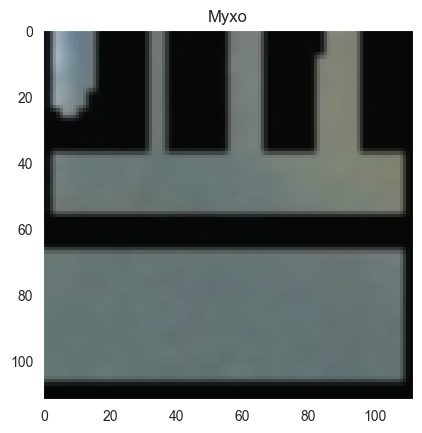

In [8]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(datasets['train']), size=1)

print('idx: ', int(idx))
print('idx type: ', type(idx))
image, label = datasets['train'][int(idx)]
print('image type: ', type(image))
print('label: ', label)
print('class name label: ', class_names[label])

# Convert torch tensor for plotting
image = image.permute(1, 2, 0)
plt.imshow(image)
plt.title(class_names[label])
plt.grid(False)
plt.show()


# Load ViT pretrained on DINOv2 with registers model

In [9]:
# DINOv2
# dinov2_vits14_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# dinov2_vitb14_86M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

# DINOv2 with registers
dinov2_vits14_reg_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_vitb14_reg_86M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
dinov2_vitl14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
dinov2_vitg14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')
# print(dinov2_vitb14_reg_86M)

Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main


# Fine-Tune model classifier and trainable parameters 

In [10]:
# Define model
model = dinov2_vits14_reg_21M

# Define classifier for Binary Classification task
model.head = nn.Sequential(
    nn.Linear(384, len(class_names))
)
print(model)

# Set about 30% of parameters trainable 
model_params = 0
for idx, param in enumerate(model.parameters()):
    param.requires_grad = False
    model_params += 1
    if idx == 100:
        break

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [11]:
from torchsummary import summary

# summary(model, input_size=(3, 224, 224))

## Defining Train function 

In [12]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).')
        self.val_loss_min = val_loss
        
    def counter(self):
        return self.counter 


In [13]:
def l1_regularization(model, lambda_l1):
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    return lambda_l1 * l1_norm


def l2_regularization(model, lambda_reg):
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    return lambda_reg * l2_norm


def custom_loss(output, target, model, lambda_reg, criterion):
    loss = criterion(output, target) + l2_regularization(model, lambda_reg)
    return loss


In [14]:
from datetime import datetime
from easydict import EasyDict


# train function 
def train_model(device, model, criterion, optimizer, dataloaders, datasets, early_stopping, lambda_reg=0.01,
                scheduler=None,
                epoch_num=25):
    acc_list = EasyDict({'train': [], 'val': []})
    loss_list = EasyDict({'train': [], 'val': []})

    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    stop_training = False

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            s0 = datetime.now()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    l1_loss = l1_regularization(model, lambda_reg)
                    total_loss = loss + l1_loss

                    _, predictions = torch.max(outputs, 1)

                    # Back Propagation and updating weights
                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = running_corrects / len(datasets[phase])

            # Show epoch details
            delta = datetime.now() - s0
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} | Loss: {epoch_loss:.4f} | time: {delta}')

            # Check for Early stopping
            if phase == 'val':
                early_stopping(epoch_loss)
                if early_stopping.early_stop:
                    print("<<<<<<<< ---| Early stopping |--- >>>>>>>>")
                    stop_training = True

            # calculate new lr
            if phase == 'val' and scheduler is not None :
                scheduler.step()
                
            # if phase == 'val' and scheduler is not None and epoch == 3:
            #     scheduler.step()                
            

            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best model weights updated!')

            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print('-' * 50)

        if stop_training:
            break

    print(f'Best Accuracy: {best_accuracy:.4f}')

    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model, acc_list, loss_list

# Train ViT-s DINOv2 with registers 
---------------
## Hyperparameters:
### optimizer: SGD with Scheduler
### criterion: CrossEntropy
### Learning Rate: 0.001
### batch size: 32
### epoch: 50

In [15]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 10, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(10, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(21632, 512)
        self.relu = nn.ReLU()
        # self.fc1 = nn.Linear(2096, 512)
        self.fc1 = nn.Linear(512, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        # print('conv1')
        out = self.layer2(out)
        # print('conv2')
        out = out.reshape(out.size(0), -1)
        out = self.relu(self.fc(out))
        # print('linear1')
        out = self.relu(self.fc1(out))
        # print('linear2')
        # out = self.relu(self.fc2(out))
        out = self.fc2(out)
        # print('linear3')
        return out


In [16]:
from torchsummary import summary

# Load a pre-trained ResNet model
# model = models.resnet50()
# print(model.fc)
# Modify the classifier for 3 classes
# in_features = model.fc.in_features
# model.fc = nn.Linear(in_features, len(class_names))
# print(model.fc)
# 
# model = LeNet5(len(class_names))

# import segmentation_models_pytorch as smp
# 
# model = smp.Unet(
#     encoder_name='resnet34',
#     encoder_weights='imagenet',
#     in_channels=3,
#     classes=2
# )

torch.manual_seed(42)
# Defining hyperparameters
criterion = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}', end='\n\n')

# Define optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.RMSprop(model.parameters(), lr=0.003, alpha=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0003)
lambda_reg = 0.00001
# Optional: Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1, verbose=True)

early_stopping = EarlyStopping(patience=6, verbose=True, delta=0.0005)

# print(model) 

model = model.to(device)
summary(model, input_size=(3, dimention, dimention))
print()

# print('|' * 100)
# print(model)
print('-' * 67)
print('Training starts at: ', datetime.now(), end='\n\n')

# train model
model, acc_lists, loss_lists = train_model(device, model, criterion, optimizer, dataloaders, datasets,
                                           scheduler=scheduler, early_stopping=early_stopping, lambda_reg=lambda_reg,
                                           epoch_num=50)

print()
print('\nTraining ends at: ', datetime.now())


your device is cuda

Adjusting learning rate of group 0 to 3.0000e-03.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 384, 8, 8]         226,176
          Identity-2              [-1, 64, 384]               0
        PatchEmbed-3              [-1, 64, 384]               0
         LayerNorm-4              [-1, 69, 384]             768
            Linear-5             [-1, 69, 1152]         443,520
           Dropout-6            [-1, 6, 69, 69]               0
            Linear-7              [-1, 69, 384]         147,840
           Dropout-8              [-1, 69, 384]               0
   MemEffAttention-9              [-1, 69, 384]               0
       LayerScale-10              [-1, 69, 384]               0
        LayerNorm-11              [-1, 69, 384]             768
           Linear-12             [-1, 69, 1536]         591,360
             GELU-13            

 ## Plot Results 

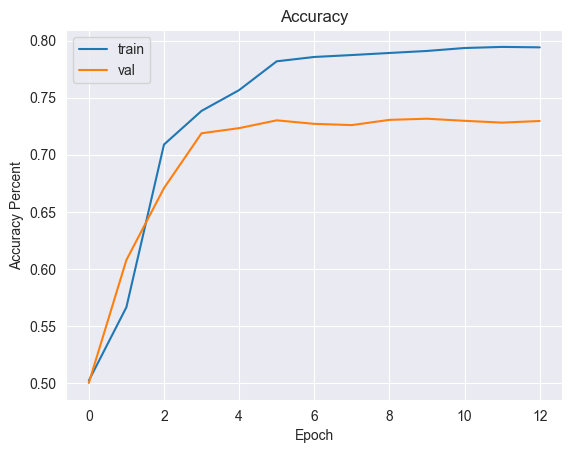

In [17]:
plt.plot([a.cpu() for a in acc_lists.train], label='train')
plt.plot([a.cpu() for a in acc_lists.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

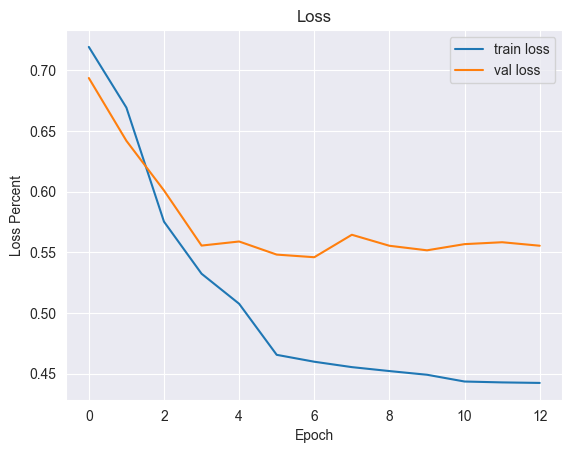

In [18]:
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()


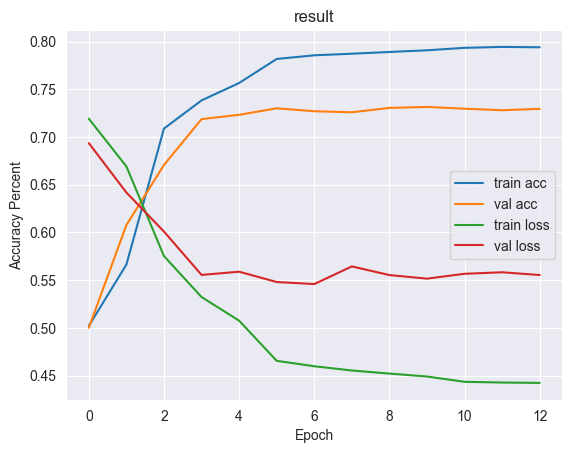

In [19]:
plt.plot([a.cpu() for a in acc_lists.train], label='train acc')
plt.plot([a.cpu() for a in acc_lists.val], label='val acc')
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.title('result')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

## Save best model weights

In [20]:
torch.save(model, '../models/model_2_5.pth')

## Visualize model predictions

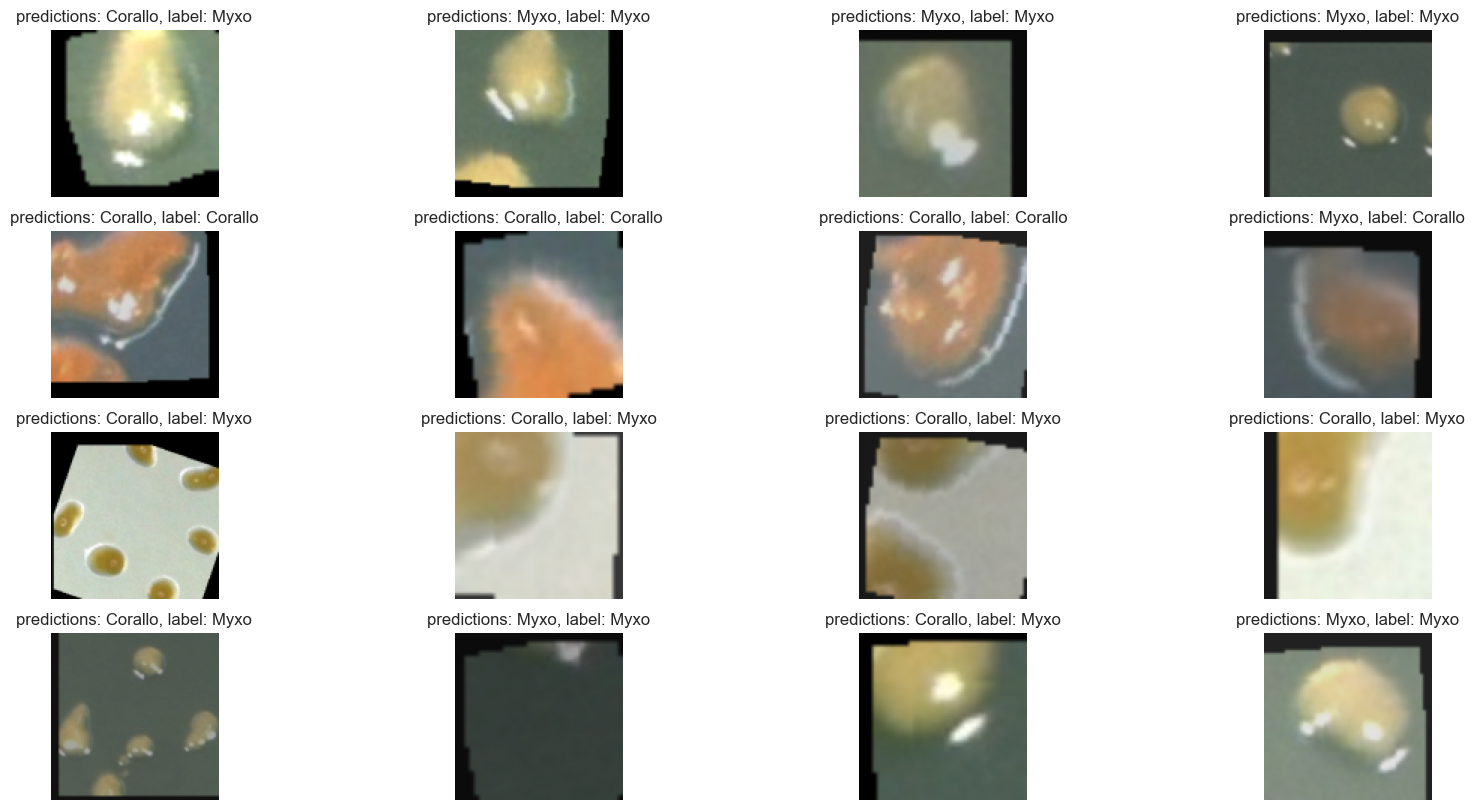

In [21]:
import itertools


def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    # Determine how many batches are in the dataloader
    num_batches = len(dataloaders['val'])
    # Generate random batch indices
    random_batches = np.random.choice(range(num_batches), size=nrows, replace=False)

    with torch.no_grad():
        for i, batch_idx in enumerate(random_batches):
            # Retrieve the batch by the random index
            inputs, labels = next(itertools.islice(dataloaders['val'], batch_idx, None))

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(ncols):
                if j >= inputs.size()[0]:  # Check if the batch is smaller than ncols
                    break

                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)  # Normalize the image for display
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)

    plt.show()


# model = torch.load('../models/model_2.pth')
visualize_model(model)

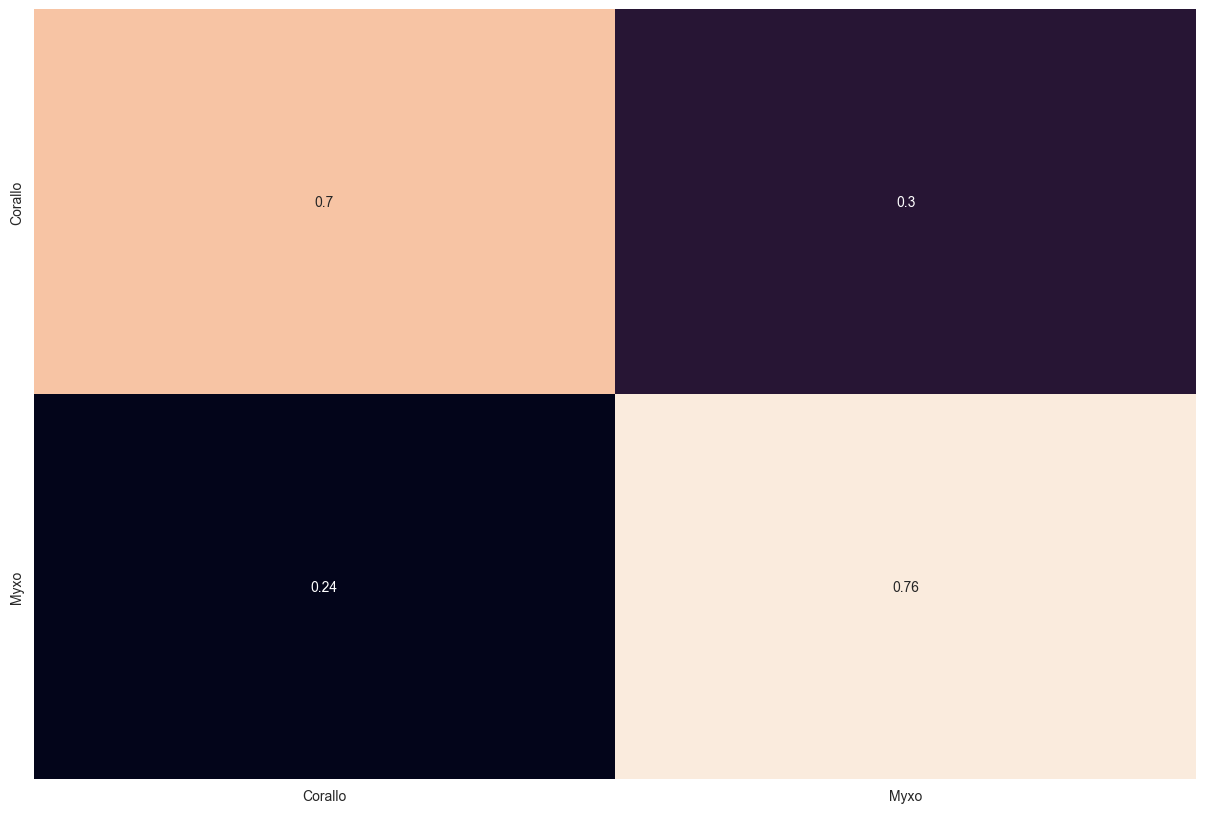

In [22]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


def plot_cm(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            outputs = model(inputs)

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(
        cm / np.sum(cm, axis=1)[:, None],
        index=[i for i in class_names],
        columns=[i for i in class_names]
    )

    plt.figure(figsize=(15, 10))
    sns.heatmap(df_cm, annot=True, cbar=False)
    plt.show()


plot_cm(model)

In [23]:
from sklearn.metrics import classification_report

def model_classification_report(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            outputs = model(inputs)
    
            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)
    
            labels = labels.data.cpu().numpy()
            y_true.extend(labels)
    return classification_report(y_true, y_pred)

class_report = model_classification_report(model)
print(class_report)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72      6000
           1       0.72      0.76      0.74      6000

    accuracy                           0.73     12000
   macro avg       0.73      0.73      0.73     12000
weighted avg       0.73      0.73      0.73     12000


In [24]:
# Define model
model2 = dinov2_vits14_reg_21M

# Define classifier for Binary Classification task
model2.head = nn.Sequential(
    nn.Linear(384, len(class_names))
)
print(model2)

# Set about 30% of parameters trainable 
model_params = 0
for idx, param in enumerate(model2.parameters()):
    param.requires_grad = False
    model_params += 1
    if idx == 30:
        break

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [27]:
from torchsummary import summary

# Load a pre-trained ResNet model
# model = models.resnet50()
# print(model.fc)
# Modify the classifier for 3 classes
# in_features = model.fc.in_features
# model.fc = nn.Linear(in_features, len(class_names))
# print(model.fc)
# 
# model = LeNet5(len(class_names))

# import segmentation_models_pytorch as smp
# 
# model = smp.Unet(
#     encoder_name='resnet34',
#     encoder_weights='imagenet',
#     in_channels=3,
#     classes=2
# )

torch.manual_seed(42)
# Defining hyperparameters
criterion = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}', end='\n\n')

# Define optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.RMSprop(model.parameters(), lr=0.003, alpha=0.9)
# optimizer = optim.Adam(model.parameters(), lr=0.0003)
lambda_reg = 0.00001
# Optional: Define a learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)

early_stopping = EarlyStopping(patience=6, verbose=True, delta=0.0005)

# print(model) 

model = model.to(device)
summary(model, input_size=(3, dimention, dimention))
print()

# print('|' * 100)
# print(model)
print('-' * 67)
print('Training starts at: ', datetime.now(), end='\n\n')

# train model
model2, acc_lists2, loss_lists2 = train_model(device, model2, criterion, optimizer, dataloaders, datasets,
                                           scheduler=scheduler, early_stopping=early_stopping, lambda_reg=lambda_reg,
                                           epoch_num=50)

print()
print('\nTraining ends at: ', datetime.now())


your device is cuda

Adjusting learning rate of group 0 to 3.0000e-03.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 384, 8, 8]         226,176
          Identity-2              [-1, 64, 384]               0
        PatchEmbed-3              [-1, 64, 384]               0
         LayerNorm-4              [-1, 69, 384]             768
            Linear-5             [-1, 69, 1152]         443,520
           Dropout-6            [-1, 6, 69, 69]               0
            Linear-7              [-1, 69, 384]         147,840
           Dropout-8              [-1, 69, 384]               0
   MemEffAttention-9              [-1, 69, 384]               0
       LayerScale-10              [-1, 69, 384]               0
        LayerNorm-11              [-1, 69, 384]             768
           Linear-12             [-1, 69, 1536]         591,360
             GELU-13            

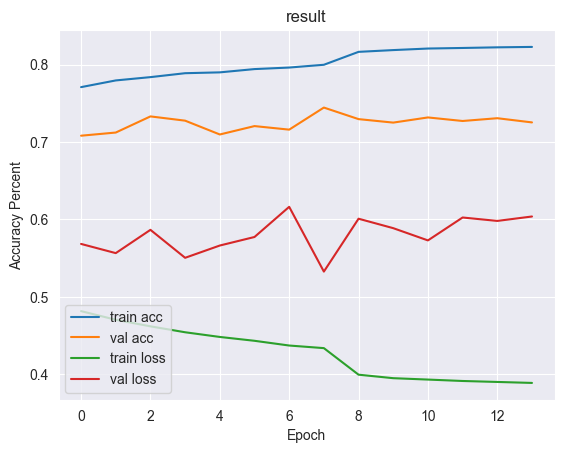

In [28]:
plt.plot([a.cpu() for a in acc_lists2.train], label='train acc')
plt.plot([a.cpu() for a in acc_lists2.val], label='val acc')
plt.plot([a for a in loss_lists2.train], label='train loss')
plt.plot([a for a in loss_lists2.val], label='val loss')
plt.title('result')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

In [ ]:
torch.save(model2, '../models/model_2_6.pth')

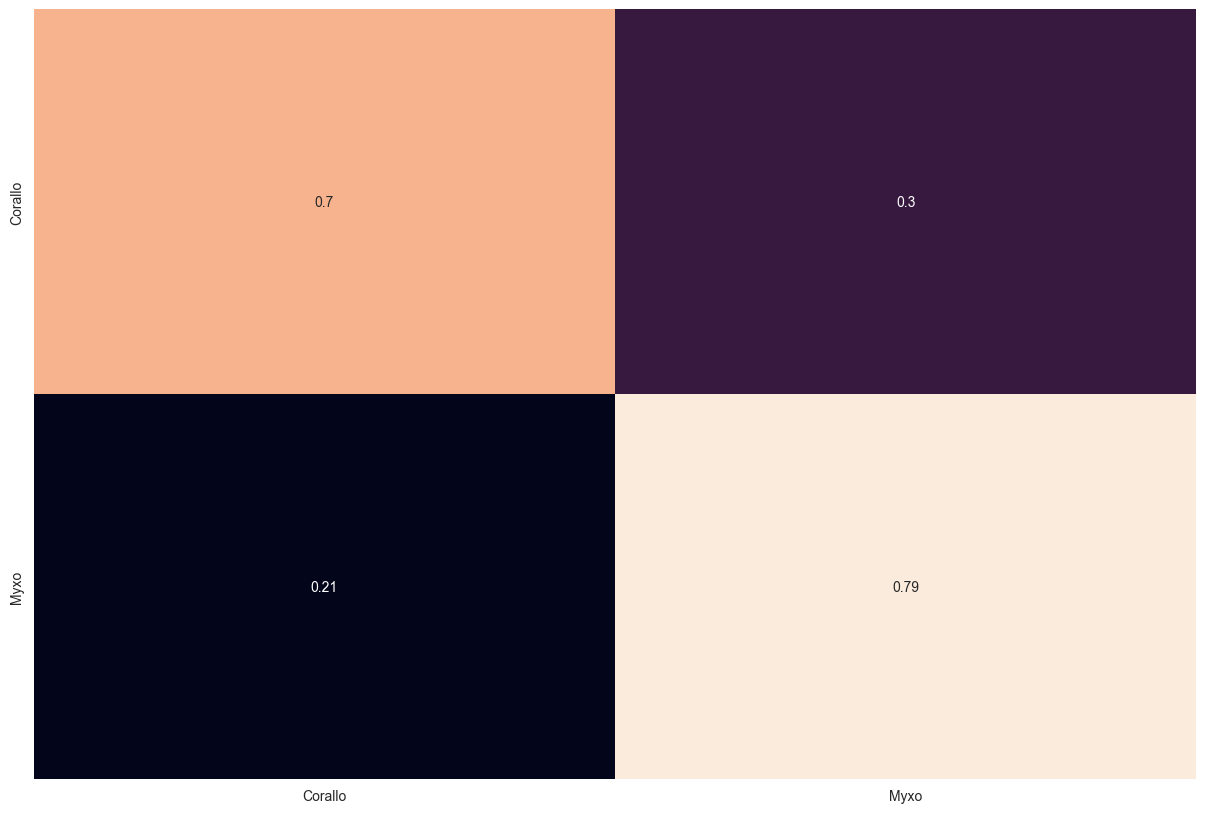

In [29]:
plot_cm(model2)


In [ ]:
class_report = model_classification_report(model2)
print(class_report)

In [ ]:
import subprocess

# For Windows
# subprocess.run("shutdown /s /t 60", shell=True)